**Note:** Running this notebook will yield somewhat different results, due to the randomness of the functions used.

In [1]:
import numpy as np
import pandas as pd
import pycharles
import random
import tensorflow as tf
import pickle
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from dython import nominal
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sympy.plotting import plot_implicit
from sympy.parsing.sympy_parser import parse_expr

/Users/shakedzy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/shakedzy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Preparing the data

In [2]:
data = pd.read_csv('train.csv').drop(['Cabin','Ticket','PassengerId'],axis=1)
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [3]:
def name_title(name):
    title = name.split(',')[1].split('.')[0].strip()
    titles_dict =   {'Capt': 'Military',
                     'Col': 'Military',
                     'Don': 'Royalty',
                     'Dr': 'Dr',
                     'Jonkheer': 'Royalty',
                     'Lady': 'Royalty',
                     'Major': 'Military',
                     'Master': 'Master',
                     'Miss': 'Miss',
                     'Mlle': 'Miss',
                     'Mme': 'Ms',
                     'Mr': 'Mr',
                     'Mrs': 'Mrs',
                     'Ms': 'Ms',
                     'Rev': 'Rev',
                     'Sir': 'Royalty',
                     'the Countess': 'Royalty'}
    return titles_dict[title]
    
data.loc[:,'Title'] = data.apply(lambda row: name_title(row['Name']),axis=1)
data.drop(['Name'],axis=1,inplace=True)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


In [4]:
titles = Counter(data['Title'])
titles

Counter({'Dr': 7,
         'Master': 40,
         'Military': 5,
         'Miss': 184,
         'Mr': 517,
         'Mrs': 125,
         'Ms': 2,
         'Rev': 6,
         'Royalty': 5})

In [5]:
avg_age = dict()
for title in titles.keys():
    df = data[data['Title'].isin([title])].dropna(subset=['Age'])
    avg_age[title] = df['Age'].sum()/len(df.index)
avg_age

{'Dr': 42.0,
 'Master': 4.574166666666667,
 'Military': 56.6,
 'Miss': 21.804054054054053,
 'Mr': 32.368090452261306,
 'Mrs': 35.898148148148145,
 'Ms': 26.0,
 'Rev': 43.166666666666664,
 'Royalty': 41.6}

In [6]:
def fix_age(row):
    if np.isnan(row['Age']):
        return avg_age[row['Title']]
    else:
        return row['Age']
    
def fix_port(row):
    if pd.isnull(row)['Embarked']:
        return '?'
    else:
        return row['Embarked']
    
data.loc[:,'Age'] = data.apply(lambda row: fix_age(row),axis=1)
data.loc[:,'Embarked'] = data.apply(lambda row: fix_port(row),axis=1)

In [7]:
nn_data = nominal.numerical_encoding(data,nominal_columns=['Sex','Embarked','Title'])
X = nn_data.drop(['Survived'],axis=1)
y = nn_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
y_train_cat = to_categorical(y_train,2)
y_test_cat = to_categorical(y_test,2)
X_train.shape

(623, 19)

## Learning the solution space
To properly evaluate the Genetic Model efficency, I've calculated the AUC of all 1050 (!!) neural networks int he solution space, using the commented-out function. It took my MacBook Pro 18 hours to complete that, so I saved as a file, which will be loaded to a dictionary contaning all possible solutions which can be selected at random (`rand_dict`). You can try recalculate everything yourself, though note that the output will be a little different due to the randomness of Keras.

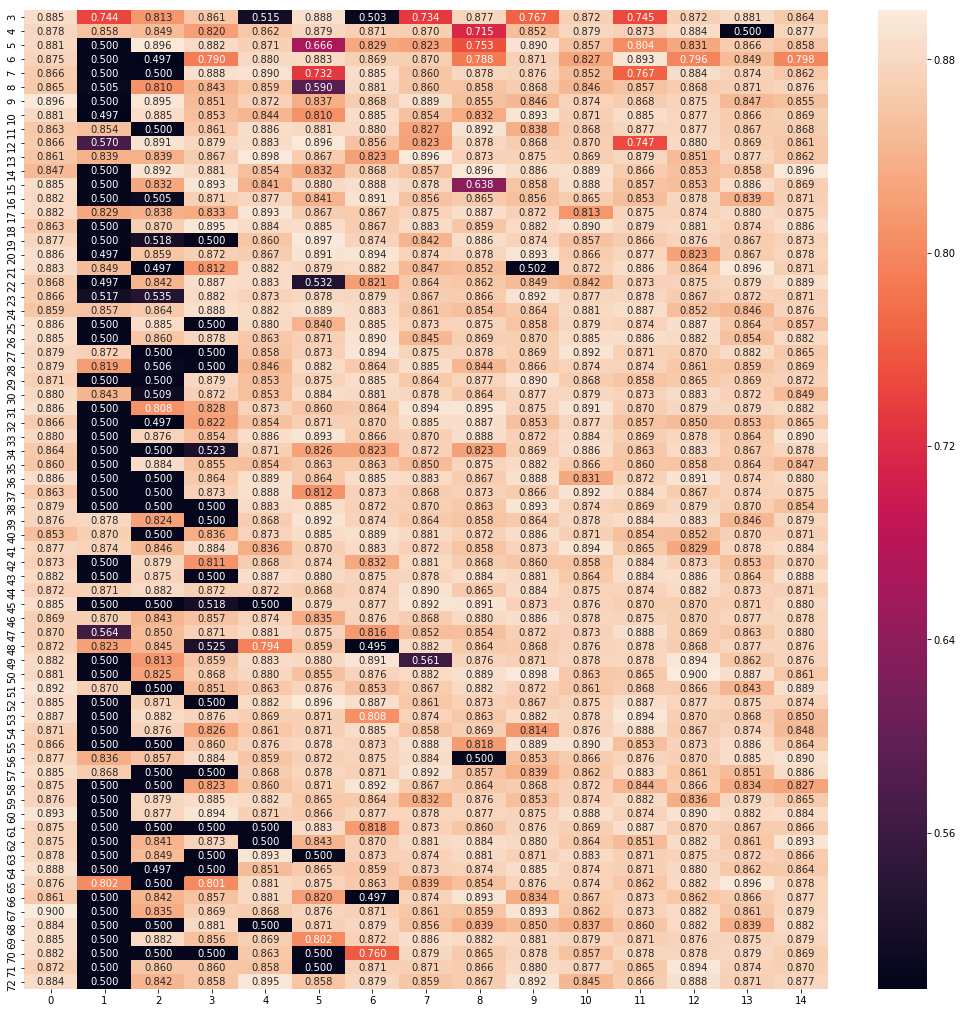

In [8]:
'''
rand_dict = dict()
for i in range(3,73):
    for j in range(0,15):
        values = [i,j]
        print('Now running: {0}'.format(values))
        auc = auc_score(values)
        key = '{0}|{1}'.format(i,j)
        rand_dict[key] = auc
'''
rand_dict = pickle.load(open('rand_dict', 'rb'))
aucs = pd.DataFrame(columns=list(range(0,15)),index=list(range(3,73)))
for k in rand_dict.keys():
    a = list(map(lambda x: int(x), k.split('|')))
    aucs.loc[a[0],a[1]]=rand_dict[k]
aucs = aucs[aucs.columns].astype(float)
plt.figure(figsize=(18,18))
sns.heatmap(aucs, annot=True, fmt='.3f')
plt.show()

In [9]:
top_nn = sorted(rand_dict, key=rand_dict.__getitem__, reverse=True)
print('Top architectures by AUC:')
for i in range(0,10):
    print(i+1,':',top_nn[i],'- AUC:',rand_dict[top_nn[i]])

Top architectures by AUC:
1 : 50|12 - AUC: 0.900212314225053
2 : 67|0 - AUC: 0.9000401675560912
3 : 50|9 - AUC: 0.8984334653124463
4 : 13|4 - AUC: 0.8982613186434842
5 : 19|5 - AUC: 0.8973432030756872
6 : 14|14 - AUC: 0.8964824697308773
7 : 12|5 - AUC: 0.8964250875078901
8 : 65|13 - AUC: 0.8963103230619154
9 : 5|2 - AUC: 0.8960807941699661
10 : 52|5 - AUC: 0.8960807941699661


## Genetic Models
The functions below will be used to evaluate the Genetic Models. `auc_score` is the main function here: it gets an array of two numbers, which represent the number of nodes in the first and second layers. It then constructs a neural network with that architecture, trains it and calculates its AUC score. `strength_function` will be used by the model to evaluate how strong is each solution. The function used here ensures that even the smallest step towards AUC = 1.0 will have a major impact. Finally, `create_chromosome` will be used to create random subjects in the population the model will examine.

In [10]:
pred_dict = dict()

def auc_score(values): 
    key = '|'.join(map(lambda x: str(x),values))
    if key in pred_dict:
        return roc_auc_score(y_test_cat,pred_dict[key])
    else:
        model = Sequential()
        model.add(Dense(values[0],activation='relu',input_shape=(19,)))
        if values[1] > 0:
            model.add(Dense(values[1],activation='relu'))
        model.add(Dense(2,activation='softmax'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        callbacks = [EarlyStopping(monitor='loss', min_delta=0, patience=2, mode='auto')]
        model.fit(X_train,y_train_cat,callbacks=callbacks,epochs=100,verbose=0)
        y_prediction = model.predict(X_test)
        pred_dict[key] = y_prediction
        return roc_auc_score(y_test_cat,y_prediction)

def strength_function(values):
    auc = auc_score(values)
    if auc == 1.0:
        return math.inf
    else:
        return 1.0/(1.0-auc)**2
    
def create_chromosome():
    return [random.randint(3,72),random.randint(0,14)]

The model will run 5 times and the scores will be averaged:

In [11]:
values = {0: list(range(3,73)), 1: list(range(0,15))}
gm_avg = 0
for i in range(0,5):
    pred_dict = dict()
    population = list()
    for _ in range(0,8):
        population.append(create_chromosome())
    gmodel = pycharles.Model(population, values, strength_function, seed=SEED, early_stop=2)
    gmodel.evolve()
    score = roc_auc_score(y_test_cat,pred_dict['|'.join(map(lambda x: str(x),gmodel.get_best()))])
    print('AUC',i+1,':',gmodel.get_best(),', AUC:',score,', No. of generations:',gmodel.get_current_generation())
    gm_avg += score
gm_avg /= 5
print('Genetic model average AUC:',gm_avg)

AUC 1 : [17, 0] , AUC: 0.8751936650025822 , No. of generations: 2
AUC 2 : [15, 3] , AUC: 0.8919492741148791 , No. of generations: 3
AUC 3 : [41, 9] , AUC: 0.8922361852298157 , No. of generations: 2
AUC 4 : [25, 3] , AUC: 0.8991794342112813 , No. of generations: 4
AUC 5 : [36, 0] , AUC: 0.8855224651402995 , No. of generations: 2
Genetic model average AUC: 0.8888162047397715


Now we'll chaeck how many solutions in the solution-space exists which are better than the average AUC score found by the model:

In [12]:
s = 0
for k in rand_dict.keys():
    if rand_dict[k] >= gm_avg:
        s += 1
print(s,s/len(rand_dict))

70 0.06666666666666667


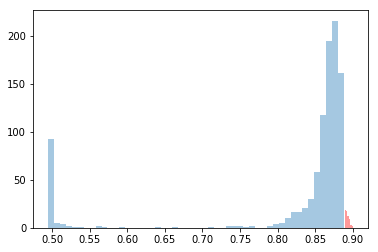

In [13]:
lower = list()
greater = list()
rounded_gm = round(gm_avg,3)
for k in rand_dict.keys():
    v = round(rand_dict[k],3)
    if v < rounded_gm:
        lower.append(v)
    else:
        greater.append(v)
sns.distplot(lower,kde=False)
sns.distplot(greater,kde=False,color='r')
plt.show()

The model's population consisted of 8 subjects, which evolved for an average of 3 generations. For every generation, 7 new solutions were created (the top solution advances to the next generation as-is). That means that the model had to compute $8+7*3=29$ neural networks before stopping at a local maximum. 
Let's now calculate how many random solutions we need to try in order to get an equal or better solution than that of the model with good probability. This is given by:
$$p=1-\left(\frac{1050-70}{1050}\right)^n$$
where $n$ is the number attempts

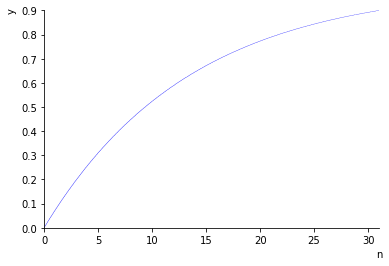

In [19]:
eq_y = parse_expr('y')
eq_x = parse_expr('1-(({all}-{greater})/{all})**n'.format(all=len(rand_dict),greater=len(greater)))
plot_implicit(eq_y-eq_x,x_var=('n',0,31),y_var=('y',0,0.9))

We see that after 30 random attempts, we'll get an equal or better solution than the one we got from the model, which is the same solution the model scanned. So it seems as Genetic Models are just as good as random selections..